In [ ]:
import glob
import math
import os
import random
import re
import shutil

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset, random_split, Subset

import torchvision
from torchvision import datasets, transforms

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 4
MANUAL_SEED = 1
HIDDEN_SIZE = 256
INPUT_SIZE = 6  # FPOGX, FPOGY, LPS, RPS, LPMM, RPMM

In [2]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"Found {num_devices} CUDA device(s):")
    for i in range(num_devices):
        print(f"CUDA:{i} - {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

Found 1 CUDA device(s):
CUDA:0 - NVIDIA GeForce RTX 3050 Laptop GPU


## Custom Dataset with User ID Extraction

This class processes scanpath images and sequences, extracting user IDs from filenames for leave-one-user-out cross-validation.

In [ ]:
class ScanpathDataset(Dataset):
    def __init__(self, img_root, seq_root, transform=None):
        self.samples = []
        self.transform = transform
        self.label_map = {"literate": 0, "illiterate": 1}

        for label_name, label in self.label_map.items():
            img_dir = os.path.join(img_root, label_name)
            seq_dir = os.path.join(seq_root, label_name)

            for img_path in glob.glob(os.path.join(img_dir, "*.png")):
                base = os.path.splitext(os.path.basename(img_path))[0]
                csv_path = os.path.join(seq_dir, base + ".csv")
                if os.path.exists(csv_path):
                    user_id = int(base.split('_')[1])
                    self.samples.append((img_path, csv_path, label, user_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        from PIL import Image
        img_path, seq_path, label, user_id = self.samples[idx]

        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        df = pd.read_csv(seq_path)
        
        required_columns = ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']
        
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"CSV file {seq_path} missing columns: {missing_cols}")

        seq = df[required_columns].values
        seq = torch.tensor(seq, dtype=torch.float32)

        return img, seq, label, user_id
    
    def get_user_ids(self):
        return [sample[3] for sample in self.samples]


In [ ]:
def collate_fn(batch):
    images, seqs, labels, user_ids = zip(*batch)

    images = torch.stack(images)

    seq_lengths = torch.tensor([len(seq) for seq in seqs])
    padded_seqs = pad_sequence(seqs, batch_first=True)

    labels = torch.tensor(labels, dtype=torch.long)
    user_ids = torch.tensor(user_ids, dtype=torch.long)

    return images, padded_seqs, seq_lengths, labels, user_ids


## VTNet Model with Attention Mechanism

This model combines:
- **CNN branch**: Extracts spatial features from scanpath images (visual patterns)
- **RNN branch**: Processes temporal sequences of eye movements (FPOGX, FPOGY, LPS, RPS, LPMM, RPMM)
- **Attention mechanism**: Uses CNN features as query to selectively attend to important timesteps in the RNN sequence

The attention allows the model to identify which temporal patterns in eye movements are most relevant given the overall spatial scanpath pattern.

In [5]:
class VTNet(nn.Module):
    def __init__(self,
                 input_size=6,
                 rnn_hidden_size=256,
                 output_size=2,
                 rnn_type='gru',
                 rnn_num_layers=1,
                 n_channels_1=6,
                 kernel_size_1=5,
                 n_channels_2=16,
                 kernel_size_2=5,
                 img_n_vert=150,
                 img_n_hor=150):
        super(VTNet, self).__init__()

        self.rnn_type = rnn_type
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        self.n_channels_2 = n_channels_2

        # --- CNN branch ---
        self.conv1 = nn.Conv2d(1, n_channels_1, kernel_size=kernel_size_1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_channels_1, n_channels_2, kernel_size=kernel_size_2)

        # calculate CNN output size
        conv1_out_vert = img_n_vert - kernel_size_1 + 1
        conv1_out_hor = img_n_hor - kernel_size_1 + 1
        mp1_out_vert = (conv1_out_vert - 2) // 2 + 1
        mp1_out_hor = (conv1_out_hor - 2) // 2 + 1
        conv2_out_vert = mp1_out_vert - kernel_size_2 + 1
        conv2_out_hor = mp1_out_hor - kernel_size_2 + 1
        mp2_out_vert = (conv2_out_vert - 2) // 2 + 1
        mp2_out_hor = (conv2_out_hor - 2) // 2 + 1

        self.fc1 = nn.Linear(n_channels_2 * mp2_out_hor * mp2_out_vert, 50)
        self.fc2 = nn.Linear(rnn_hidden_size + 50, 20)
        # --- Attention projection layers ---
        # project CNN features -> query, and RNN outputs -> keys/values
        self.attn_query = nn.Linear(50, rnn_hidden_size)
        self.attn_key = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.attn_value = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.fc3 = nn.Linear(20, output_size)

        # --- RNN branch ---
        if rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=rnn_hidden_size,
                               num_layers=rnn_num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers, batch_first=True)

    def forward(self, scan_path, time_series, seq_lengths):
        # --- CNN branch ---
        x1 = self.pool(F.relu(self.conv1(scan_path)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = x1.view(x1.size(0), -1)
        x1 = F.relu(self.fc1(x1))

        # --- RNN branch ---
        packed = pack_padded_sequence(time_series, seq_lengths.cpu(),
                                      batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        # --- Attention mechanism ---
        # out: (B, T, H) where H = rnn_hidden_size
        # We'll compute dot-product attention: query from CNN features, keys/values from RNN outputs
        # Project query (from CNN) to rnn_hidden_size
        # query: (B, H)
        query = self.attn_query(x1)  # (B, H)

        # keys, values: project RNN outputs
        # keys/values: (B, T, H)
        keys = self.attn_key(out)
        values = self.attn_value(out)

        # compute attention scores: (B, T)
        scores = torch.bmm(query.unsqueeze(1), keys.transpose(1, 2)).squeeze(1)

        # create mask for padded positions: (B, T)
        max_len = out.size(1)
        device = out.device
        seq_range = torch.arange(0, max_len, device=device).unsqueeze(0)  # (1, T)
        seq_lengths_exp = seq_lengths.unsqueeze(1)
        mask = seq_range >= seq_lengths_exp  # True where padding

        # apply mask: set scores at padding positions to large negative value
        scores = scores.masked_fill(mask, float('-inf'))

        attn_weights = F.softmax(scores, dim=1)  # (B, T)

        # weighted sum of values: (B, T, H) * (B, T, 1) -> (B, H)
        context = torch.bmm(attn_weights.unsqueeze(1), values).squeeze(1)

        # --- combine CNN + attention-context ---
        x = torch.cat((x1, context), 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Leave-One-User-Out Cross-Validation

This section performs leave-one-user-out cross-validation where:
1. Each unique user is held out as a test set
2. All other users are used for training
3. The model is trained and evaluated for each user
4. Results are aggregated across all users

This approach evaluates how well the model generalizes to completely unseen users.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = ScanpathDataset("Scanpaths/all", "Raw Data/all", transform=transform)
print("Total samples:", len(dataset))

# ------------------------------------------------
# Get unique users for LOUO CV
# ------------------------------------------------
unique_users = dataset.get_unique_users()
print(f"Number of unique users: {len(unique_users)}")
print(f"User IDs: {unique_users}")

# Get all user IDs from dataset
all_user_ids = dataset.get_user_ids()

# Store metrics for each user
user_metrics = []
per_user_results = []

# ------------------------------------------------
# Leave-One-User-Out Cross-Validation
# ------------------------------------------------
for fold_idx, test_user in enumerate(unique_users):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx+1}/{len(unique_users)} - Testing on User {test_user}")
    print(f"{'='*60}")
    
    # Split dataset: train on all users except test_user
    train_indices = [i for i, uid in enumerate(all_user_ids) if uid != test_user]
    test_indices = [i for i, uid in enumerate(all_user_ids) if uid == test_user]
    
    print(f"Training samples: {len(train_indices)}")
    print(f"Test samples: {len(test_indices)}")
    
    # Create subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_subset, batch_size=4, shuffle=False, collate_fn=collate_fn)
    
    # Get input size from first sample
    sample_img, sample_seq, _, _ = dataset[0]
    input_size = sample_seq.shape[1]
    
    # Initialize model for this fold
    model = VTNet(input_size=input_size, rnn_type='gru').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # -----------------------------
    # Training
    # -----------------------------
    num_epochs = 50
    best_train_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        
        for images, sequences, seq_lengths, labels, user_ids in train_loader:
            images, sequences, seq_lengths, labels = (
                images.to(device),
                sequences.to(device),
                seq_lengths.to(device),
                labels.to(device)
            )
            optimizer.zero_grad()
            outputs = model(images, sequences, seq_lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")
    
    # -----------------------------
    # Testing on held-out user
    # -----------------------------
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for images, sequences, seq_lengths, labels, user_ids in test_loader:
            images, sequences, seq_lengths, labels = (
                images.to(device),
                sequences.to(device),
                seq_lengths.to(device),
                labels.to(device)
            )
            outputs = model(images, sequences, seq_lengths)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
    
    # Compute metrics for this user
    acc = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_true, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_true, all_preds, average="macro", zero_division=0)
    
    user_metrics.append((acc, precision, recall, f1))
    per_user_results.append({
        'user_id': test_user,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'n_samples': len(test_indices)
    })
    
    print(f"\nUser {test_user} Results:")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-score:  {f1:.3f}")

# ------------------------------------------------
# Average metrics across all users
# ------------------------------------------------
user_metrics = np.array(user_metrics)
mean_metrics = user_metrics.mean(axis=0)
std_metrics = user_metrics.std(axis=0)

print(f"\n{'='*60}")
print("LEAVE-ONE-USER-OUT CROSS-VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Accuracy:  {mean_metrics[0]:.3f} ± {std_metrics[0]:.3f}")
print(f"Precision: {mean_metrics[1]:.3f} ± {std_metrics[1]:.3f}")
print(f"Recall:    {mean_metrics[2]:.3f} ± {std_metrics[2]:.3f}")
print(f"F1-score:  {mean_metrics[3]:.3f} ± {std_metrics[3]:.3f}")
print(f"{'='*60}")

Total samples: 1499
Number of unique users: 30
User IDs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Fold 1/30 - Testing on User 1
Training samples: 1449
Test samples: 50
Epoch [10/50] | Loss: 0.4260 | Train Acc: 79.85%
Epoch [10/50] | Loss: 0.4260 | Train Acc: 79.85%
Epoch [20/50] | Loss: 0.1761 | Train Acc: 93.51%
Epoch [20/50] | Loss: 0.1761 | Train Acc: 93.51%
Epoch [30/50] | Loss: 0.0533 | Train Acc: 98.48%
Epoch [30/50] | Loss: 0.0533 | Train Acc: 98.48%
Epoch [40/50] | Loss: 0.0298 | Train Acc: 99.17%
Epoch [40/50] | Loss: 0.0298 | Train Acc: 99.17%
Epoch [50/50] | Loss: 0.0216 | Train Acc: 99.31%
Epoch [50/50] | Loss: 0.0216 | Train Acc: 99.31%

User 1 Results:
  Accuracy:  0.020
  Precision: 0.500
  Recall:    0.010
  F1-score:  0.020

Fold 2/30 - Testing on User 2
Training samples: 1449
Test samples: 50

User 1 Results:
  Accuracy:  0.020
  Precision: 0.500
  Recall:    0.010
  F1-score:  0.020

Fold 2/30 -

## Per-User Results Analysis

View detailed results for each individual user.

In [7]:
# Create DataFrame with per-user results
results_df = pd.DataFrame(per_user_results)
results_df = results_df.sort_values('accuracy', ascending=False)

print("\nPer-User Performance (sorted by accuracy):")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('vtnet_6col_louo_results.csv', index=False)
print("\nResults saved to 'vtnet_6col_louo_results.csv'")


Per-User Performance (sorted by accuracy):
 user_id  accuracy  precision   recall  f1_score  n_samples
       2  1.000000        1.0 1.000000  1.000000         50
       4  0.980000        0.5 0.490000  0.494949         50
      27  0.920000        0.5 0.460000  0.479167         50
      11  0.918367        0.5 0.459184  0.478723         49
      13  0.900000        0.5 0.450000  0.473684         50
       8  0.880000        0.5 0.440000  0.468085         50
      18  0.860000        0.5 0.430000  0.462366         50
      32  0.780000        0.5 0.390000  0.438202         50
      23  0.740000        0.5 0.370000  0.425287         50
       3  0.720000        0.5 0.360000  0.418605         50
       6  0.700000        0.5 0.350000  0.411765         50
      19  0.660000        0.5 0.330000  0.397590         50
      17  0.640000        0.5 0.320000  0.390244         50
      15  0.460000        0.5 0.230000  0.315068         50
       7  0.440000        0.5 0.220000  0.305556        

## Visualize Results Distribution

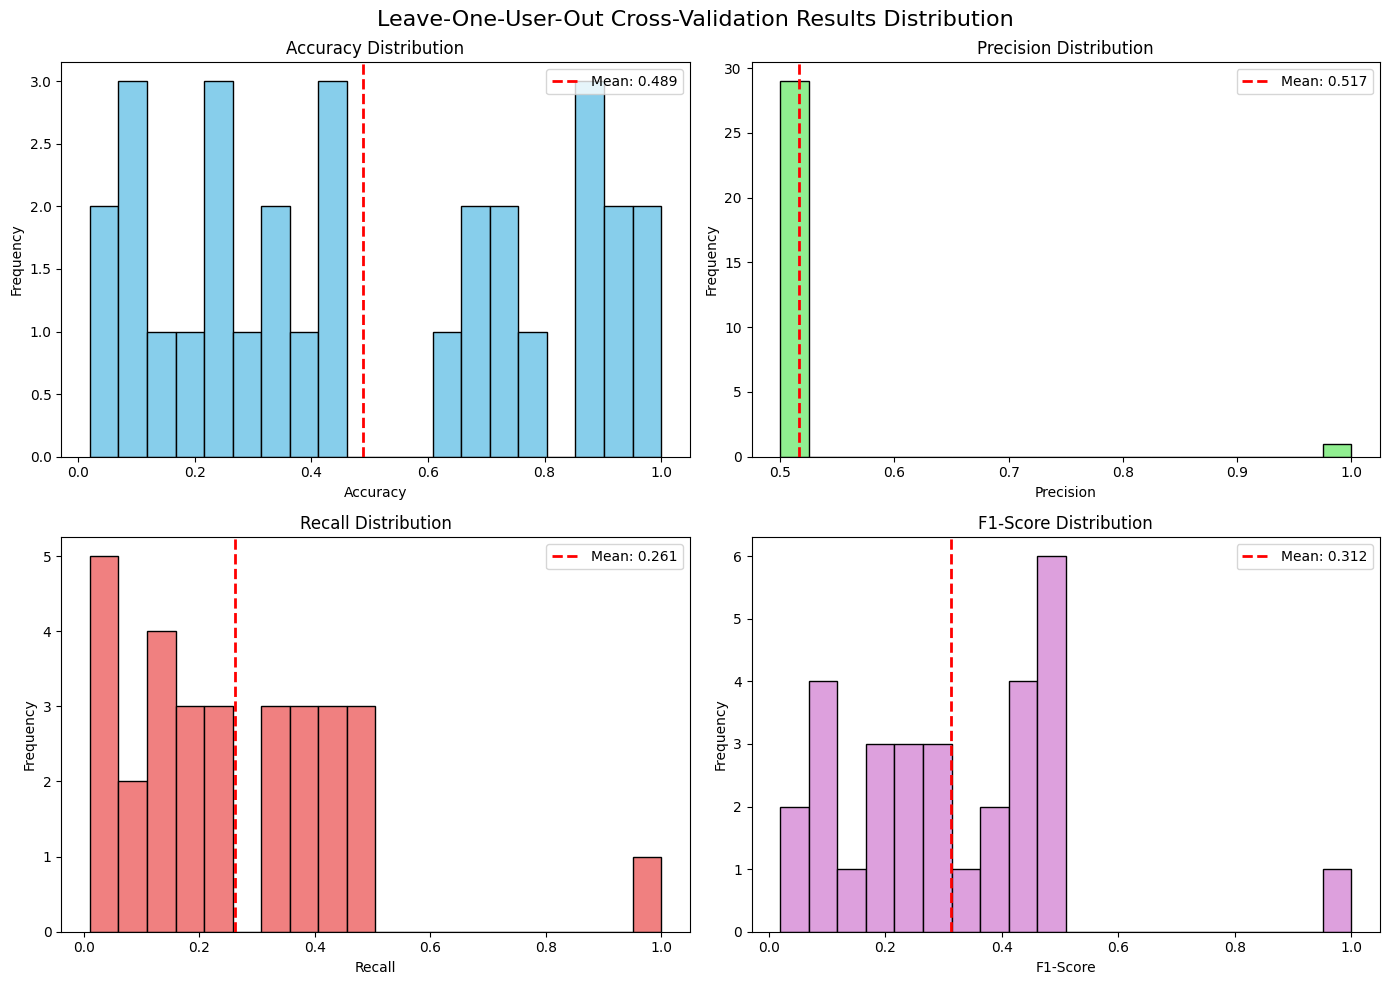

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Leave-One-User-Out Cross-Validation Results Distribution', fontsize=16)

# Accuracy distribution
axes[0, 0].hist(results_df['accuracy'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].axvline(mean_metrics[0], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[0]:.3f}')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Accuracy Distribution')
axes[0, 0].legend()

# Precision distribution
axes[0, 1].hist(results_df['precision'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(mean_metrics[1], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[1]:.3f}')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Precision Distribution')
axes[0, 1].legend()

# Recall distribution
axes[1, 0].hist(results_df['recall'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(mean_metrics[2], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[2]:.3f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Recall Distribution')
axes[1, 0].legend()

# F1-score distribution
axes[1, 1].hist(results_df['f1_score'], bins=20, color='plum', edgecolor='black')
axes[1, 1].axvline(mean_metrics[3], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[3]:.3f}')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('F1-Score Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Box Plot of Metrics

C:\Users\eloto\AppData\Local\Temp\ipykernel_24724\4232388650.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([metrics_data['accuracy'], metrics_data['precision'],


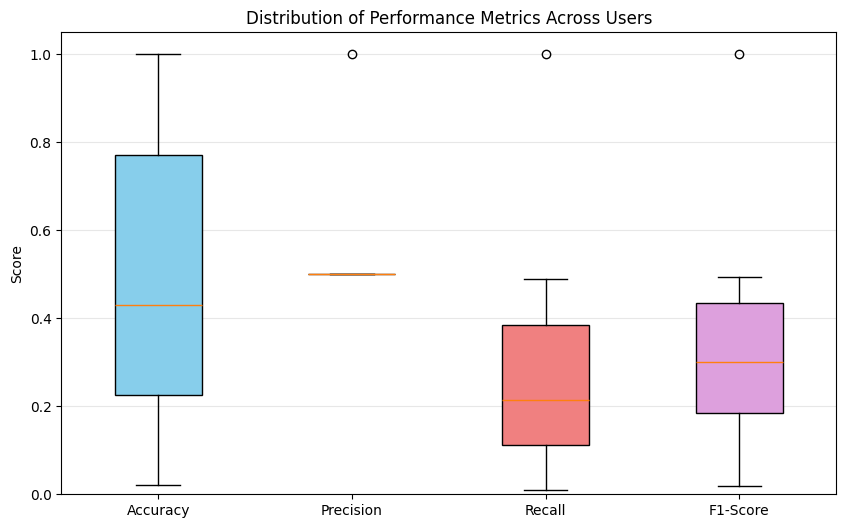

In [9]:
# Create box plot for all metrics
metrics_data = results_df[['accuracy', 'precision', 'recall', 'f1_score']]

plt.figure(figsize=(10, 6))
bp = plt.boxplot([metrics_data['accuracy'], metrics_data['precision'], 
                   metrics_data['recall'], metrics_data['f1_score']],
                  labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  patch_artist=True)

# Color the boxes
colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Score')
plt.title('Distribution of Performance Metrics Across Users')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.05)
plt.show()

## User Performance Heatmap

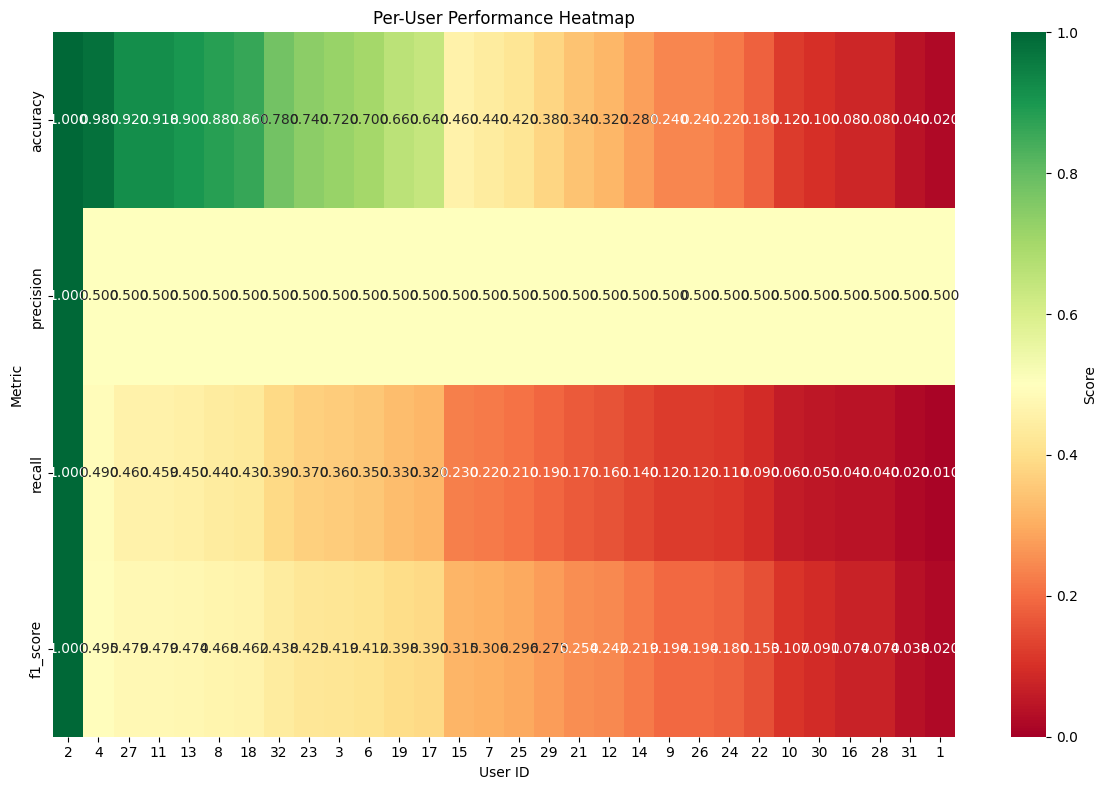

In [10]:
# Create heatmap of user performance
plt.figure(figsize=(12, 8))
heatmap_data = results_df.set_index('user_id')[['accuracy', 'precision', 'recall', 'f1_score']]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
plt.title('Per-User Performance Heatmap')
plt.xlabel('User ID')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

## Statistical Summary

In [11]:
# Detailed statistical summary
print("\nDetailed Statistical Summary:")
print("="*60)
summary_stats = results_df[['accuracy', 'precision', 'recall', 'f1_score']].describe()
print(summary_stats)

# Best and worst performing users
print("\n" + "="*60)
print("Top 5 Users by Accuracy:")
print(results_df.nlargest(5, 'accuracy')[['user_id', 'accuracy', 'f1_score', 'n_samples']])

print("\nBottom 5 Users by Accuracy:")
print(results_df.nsmallest(5, 'accuracy')[['user_id', 'accuracy', 'f1_score', 'n_samples']])


Detailed Statistical Summary:
        accuracy  precision     recall   f1_score
count  30.000000  30.000000  30.000000  30.000000
mean    0.488612   0.516667   0.260973   0.312319
std     0.325849   0.091287   0.209033   0.199395
min     0.020000   0.500000   0.010000   0.019608
25%     0.225000   0.500000   0.112500   0.183633
50%     0.430000   0.500000   0.215000   0.300665
75%     0.770000   0.500000   0.385000   0.434974
max     1.000000   1.000000   1.000000   1.000000

Top 5 Users by Accuracy:
    user_id  accuracy  f1_score  n_samples
1         2  1.000000  1.000000         50
3         4  0.980000  0.494949         50
24       27  0.920000  0.479167         50
9        11  0.918367  0.478723         49
11       13  0.900000  0.473684         50

Bottom 5 Users by Accuracy:
    user_id  accuracy  f1_score  n_samples
0         1      0.02  0.019608         50
28       31      0.04  0.038462         50
14       16      0.08  0.074074         50
25       28      0.08  0.074074   